In [23]:
# Install xgboost in notebook instance.
!pip install xgboost==1.2
!pip install imbalanced-learn==0.9.1

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [37]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb_lib
from sklearn.linear_model import LogisticRegression

import sklearn

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

In [25]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


# 5. Prepare dataframes for modeling approaches

Build temporary **DaysLate** column

In [26]:
def calc_delta(row):
    days = (row['FechaPago'] - row['FechaVencimiento'])
    return days if days > 0 else 0

df['DaysLate'] = df.apply(calc_delta, axis=1)

# Remove "FechaPago" feature
df.drop("FechaPago", axis=1, inplace=True)

df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,DaysLate
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,0.0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,0.0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,0.0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,1.0
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,0.0


TODO
Build target column **PaidTime**
> * 1: On time
> * 2: Late payment 1-3 days
> * 3: Late payment 4-7 days
> * 4: Late payment 8-14 days
> * 5: Late payment >= 15 days

In [27]:
def build_paidTime(row):
    if row.DaysLate == 0:
        return 1
    if row.DaysLate <= 3:
        return 2
    if row.DaysLate <= 7:
        return 3
    if row.DaysLate <= 14:
        return 4
    else:
        return 5

df['PaidTime'] = df.apply(build_paidTime, axis=1)

df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,DaysLate,PaidTime
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,0.0,1
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,0.0,1
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,0.0,1
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,1.0,2
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,0.0,1


In [28]:
# Remove "DaysLate" because it's not gonna be needed anymore
df.drop("DaysLate", axis=1, inplace=True)
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,PaidTime
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,1
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,1
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,1
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,2
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,1


Separate target for predictions

In [29]:
X = df.drop(['PaidTime'], axis=1)
y = df.PaidTime

In [30]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (14966, 8)
Test dataset shape:  (3742, 8)


In [87]:
# Helper function to plot confusion matrix
def render_confusion_matrix(y_test_input, predicted, clasess):
    ac_s = accuracy_score(y_test_input, predicted)
    print('The Accuracy is: ', int(ac_s * 100), " %")

    cm = confusion_matrix(y_test_input, predicted, labels=clasess)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasess)
    disp.plot()
    return ac_s

In [96]:
# Helper function to plot models accuracies
def plot_models_accuracy(models_name, accuracies):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(models_name,accuracies)
    _ = plt.xticks(rotation=90,fontsize=14)
    plt.title('Compare accuracy (test)')
    plt.ylim(0.30, 1.0)
    plt.show()   

## 5.1 Decision Tree Classifier

The Accuracy is:  85  %


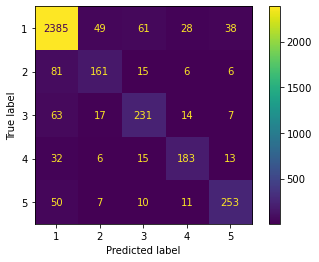

In [89]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_tree, tree.classes_)
# ac_tree = accuracy_score(y_test, predicted_tree)
# print('The Accuracy for DecisionTreeClassifier is: ', int(ac_tree * 100), " %")

# cm = confusion_matrix(y_test, predicted_tree, labels=tree.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
# disp.plot()

['Fecha', 'RFCCliente', 'RFCPagador', 'Moneda', 'FechaVencimiento', 'Monto', 'DepositoInicial', 'Intereses']


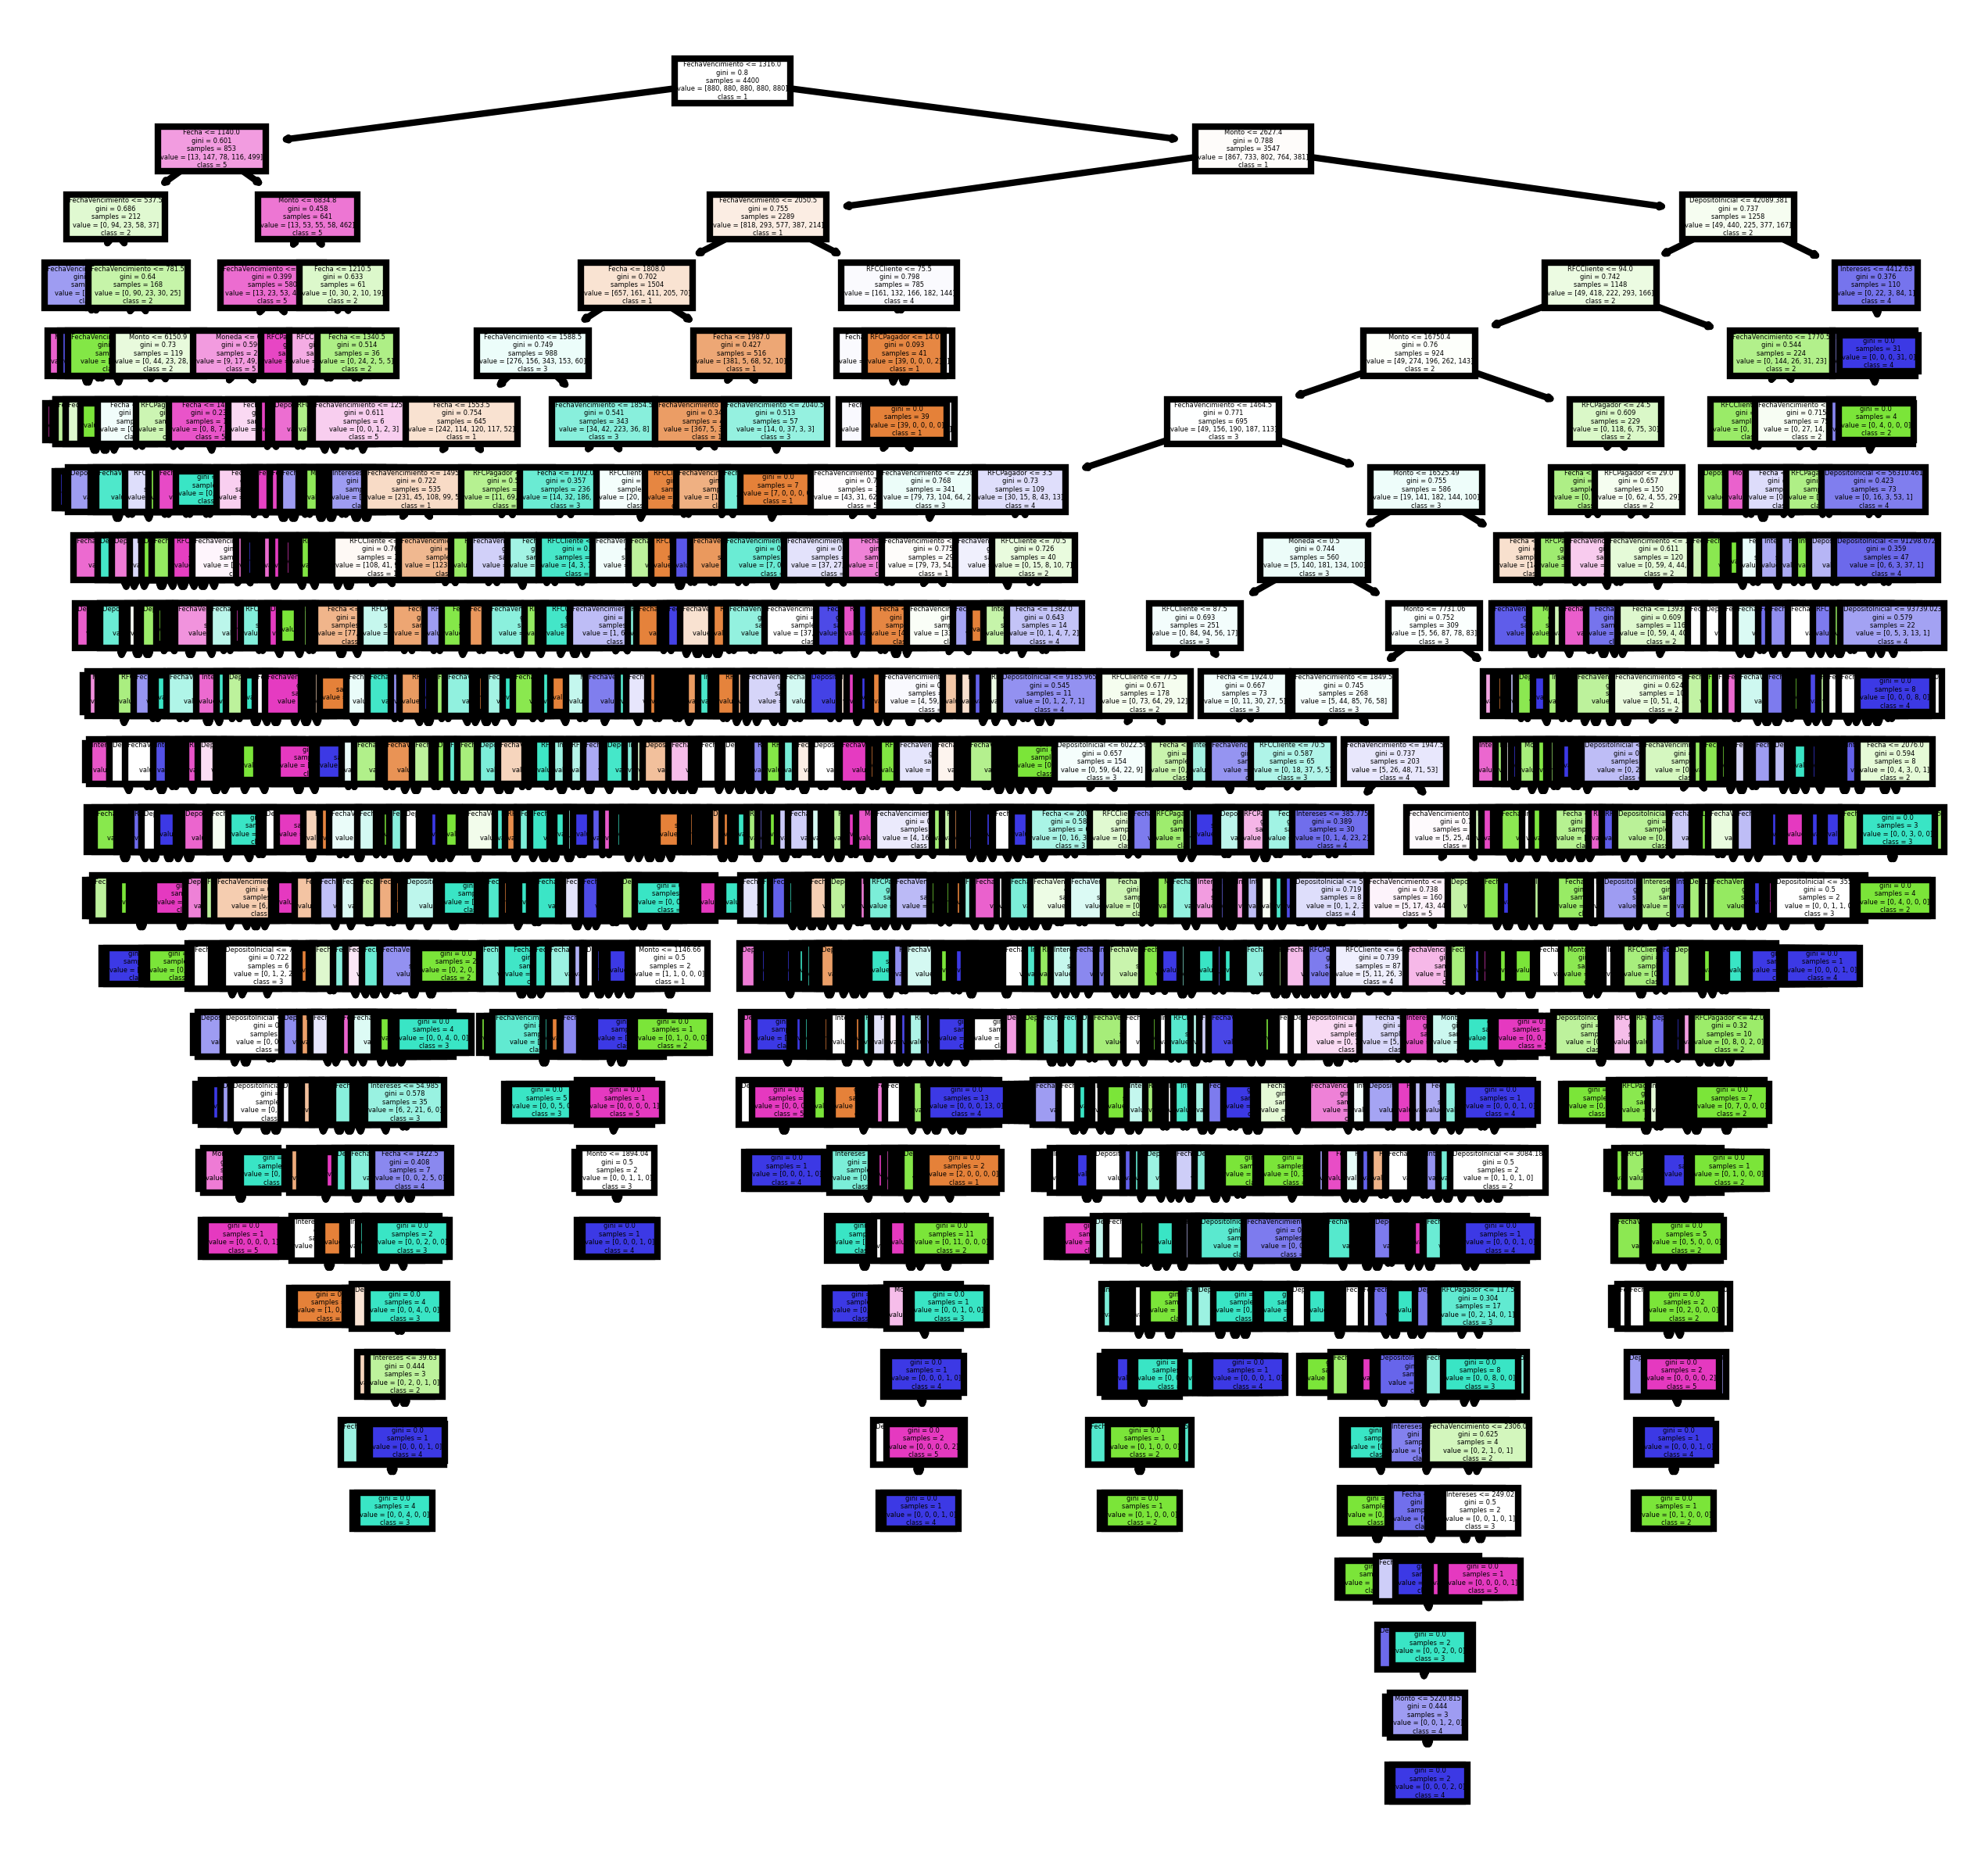

In [129]:
from sklearn import tree as sk_tree
fn = list(X_train.columns.values)
print(fn)
cn = ['1','2','3','4','5']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=600)
sk_tree.plot_tree(
    tree,
    feature_names=fn,
    class_names=cn,
    filled=True
)
fig.savefig('imagename.png')

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({1: 880, 2: 880, 3: 880, 4: 880, 5: 880})
The Accuracy is:  36  %


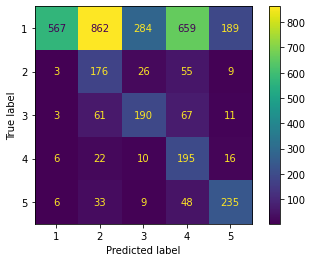

In [95]:
us = NearMiss()

X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

tree = tree.fit(X_train_res, y_train_res)

predicted_tree = tree.predict(X_test)

ac_under_sampling = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution labels after resampling Counter({1: 10371, 4: 10371, 5: 10371, 2: 10371, 3: 10371})
The Accuracy is:  83  %


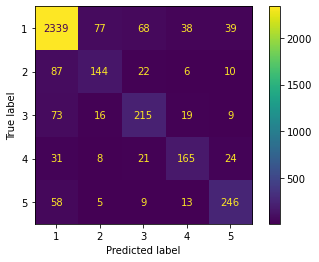

In [92]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))
 
tree = tree.fit(X_train_res, y_train_res)

predicted_tree = tree.predict(X_test)

ac_over_sampling = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({5: 10037, 4: 10025, 2: 10015, 3: 10011, 1: 9725})
The Accuracy is:  76  %


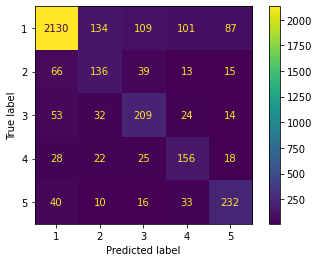

In [93]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

tree = tree.fit(X_train_res, y_train_res)

predicted_tree = tree.predict(X_test)

ac_mixed = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

### 5.1.1 Decision Tree accuracies

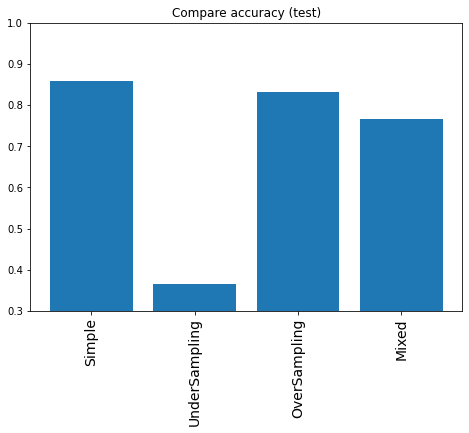

In [97]:
accuracies = [ac_simple, ac_under_sampling, ac_over_sampling, ac_mixed]
models_name = ['Simple', 'UnderSampling', 'OverSampling', 'Mixed']
plot_models_accuracy(models_name, accuracies)

## 5.2 XGBoost Classifier

The Accuracy is:  84  %


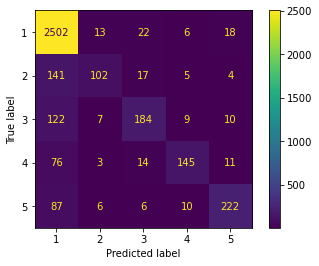

In [98]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    max_depth=3,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    verbosity=0,
                    use_label_encoder=False)

xgb = xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_xgb, xgb.classes_)

# ac_xgb = accuracy_score(y_test, predicted_xgb)
# print('The Accuracy for XGBClassifier is: ', int(ac_xgb * 100), " %")

# cm = confusion_matrix(y_test, predicted_xgb, labels=xgb.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
# disp.plot()

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({1: 880, 2: 880, 3: 880, 4: 880, 5: 880})
The Accuracy is:  36  %


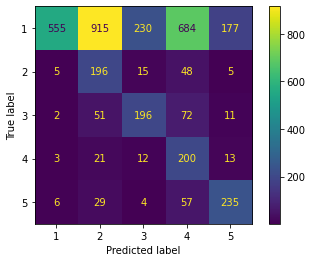

In [99]:
us = NearMiss()

X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

xgb = xgb.fit(X_train_res, y_train_res)

predicted = xgb.predict(X_test)

ac_under_sampling = render_confusion_matrix(y_test, predicted, xgb.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution labels after resampling Counter({1: 10371, 4: 10371, 5: 10371, 2: 10371, 3: 10371})
The Accuracy is:  78  %


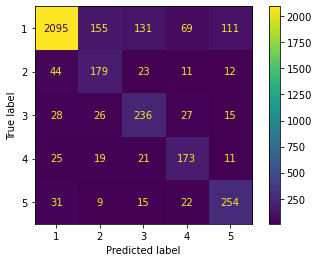

In [100]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

xgb = xgb.fit(X_train_res, y_train_res)

predicted = xgb.predict(X_test)

ac_over_sampling = render_confusion_matrix(y_test, predicted, xgb.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({5: 10042, 2: 10036, 4: 10003, 3: 9984, 1: 9714})
The Accuracy is:  75  %


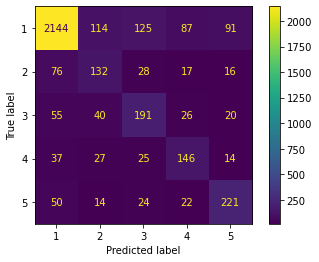

In [101]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

xgb = xgb.fit(X_train_res, y_train_res)

predicted = xgb.predict(X_test)

ac_mixed = render_confusion_matrix(y_test, predicted, xgb.classes_)

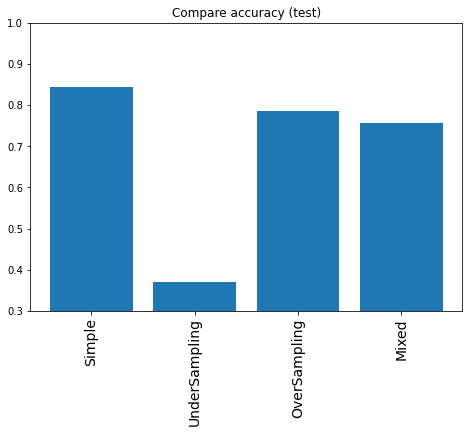

In [102]:
accuracies = [ac_simple, ac_under_sampling, ac_over_sampling, ac_mixed]
plot_models_accuracy(models_name, accuracies)

## 5.3 LogisticRegression

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The Accuracy is:  63  %


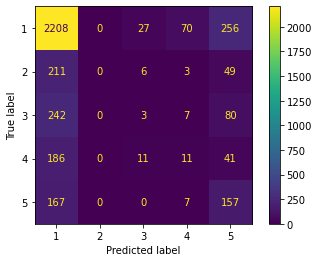

In [104]:
logr = LogisticRegression(random_state=1,solver='liblinear',penalty='l1',C=1.0,class_weight="balanced",max_iter=1000)

logr.fit(X_train, y_train)

predicted_logr = logr.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_logr, logr.classes_)

# ac_logr = accuracy_score(y_test, predicted_logr)
# print('The Accuracy for LogisticRegression is: ', int(ac_logr * 100), " %")

# cm = confusion_matrix(y_test, predicted_logr)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_)
# disp.plot()

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({1: 880, 2: 880, 3: 880, 4: 880, 5: 880})


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The Accuracy is:  20  %


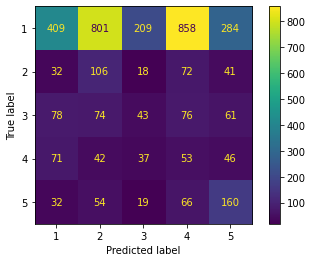

In [105]:
# Under sampling strategy
us = NearMiss()

X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

logr.fit(X_train_res, y_train_res)

predicted_logr = logr.predict(X_test)

ac_under_sampling = render_confusion_matrix(y_test, predicted_logr, logr.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution labels after resampling Counter({1: 10371, 4: 10371, 5: 10371, 2: 10371, 3: 10371})


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The Accuracy is:  41  %


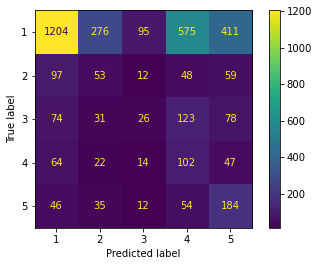

In [106]:
# Over sampling strategy
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))
 
logr.fit(X_train_res, y_train_res)

predicted_logr = logr.predict(X_test)

ac_over_sampling = render_confusion_matrix(y_test, predicted_logr, logr.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({5: 10057, 2: 10031, 4: 10015, 3: 9979, 1: 9723})


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The Accuracy is:  33  %


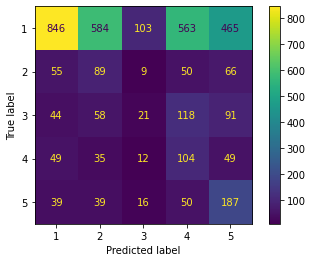

In [107]:
# Mix over sampling with under sampling strategies SMOTE Tomek
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

logr.fit(X_train_res, y_train_res)

predicted_logr = logr.predict(X_test)

ac_mixed = render_confusion_matrix(y_test, predicted_logr, logr.classes_)

In [ ]:
# Ensamble de Modelos con Balanceo
# Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un DecisionTree
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,.
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
pred_y = bbc.predict(X_test)


ac_ensemble = render_confusion_matrix(y_test, pred_y, logr.classes_)

# ac_logr = accuracy_score(y_test, pred_y)
# print('The Accuracy for LogisticRegression is: ', int(ac_logr * 100), " %")

# cm = confusion_matrix(y_test, pred_y)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_)
# disp.plot()

In [ ]:
accuracies = [ac_simple, ac_under_sampling, ac_over_sampling, ac_mixed]
plot_models_accuracy(models_name, accuracies)

## 5.4 Compare models output

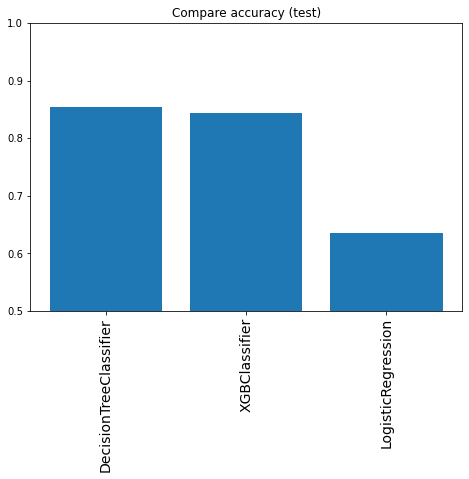

In [85]:
accuracies = [ac_tree, ac_xgb, ac_logr]
models_name = ['DecisionTreeClassifier', 'XGBClassifier', 'LogisticRegression']
plot_models_accuracy(models_name, accuracies)